#1.

Using the graphs below, draw the decision boundaries for the following binary classifiers:

- decision tree
- perceptron
- k nearest neighbors (k=1)
- k nearest neighbors (k=2)

![alt text](https://drive.google.com/uc?id=1NjHQfWad2yW3C4USvQ4PCeB9_1-jlFBe)

---

Answer: ![alt text](https://drive.google.com/uc?id=1uHqbKej-e3nN8WXy97228PlcW894a3jX)

---

#2.

Consider the confusion matrix below for a machine learning algorithm that recognizes daily activities from motion sensor data. Where needed, treat bed-toilet transition as the positive class.

![alt text](https://drive.google.com/uc?id=1kHQz2qYqPZm3L8gWfTA_iasBw84kSPI6)

Evaluate the classifier's performance using the following metrics:

- accuracy
- precision (for bed-toilet transition)
- recall (for bed-toilet transition)
- macro f-measure


---

Answer: 

- accuracy. This is the numbers along the diagonal divided by the sum of all the numbers, 49274/49538 = 0.99467.

- precision. This is TP/(TP+FP), or 501/(51+0+0+5+501+0) = 0.89946.

- recall. This is TP(TP+FN), or 501/(18+0+0+2+501+0) = 0.96161.



- f-measure. This computes 2*precision*recall/precision+recall averaged over the number of classes.

f-measure (sleep) = 0.99588
f-measure (meds) = 0.99903
f-measure (eat) = 0.99367
f-measure(bathe) = 0.99329
f-measure (btt) = 2*0.96161*0.89946/0.96161+0.89946 = 0.9295
f-measure(relax) = 0.85714

---

#3.

The table below shows how learning algorithms A and B performed for 10 different holdout sets of data. Using these results, determine if the the differences in performance are statistically significant and whether they are extremely statistically significant. Show all of your work.

A | B
--- | ---
5 | 20
3 | 13
5 | 13
12 | 20
15 | 29
16 | 32
17 | 23
19 | 20
20 | 25
24 | 15

---

Answer: The mean performance for A is 13.6 and for B is 21, with a difference between the means of -7.4. After normalizing the results based on these means, the sum of squared differences is 500.4. The number of data points is 10, so the t value is calculated as $-7.4 \sqrt{\frac{90}{500.4}} = -3.1383$. Using the lookup table with a degrees of freedom (df) of 9, we see that the absolute value of t is larger than both 2.262 ($p<.05$) and 2.821 ($p<.02$). Thus, we conclude that the difference is statistically significant and extremely statistically significant.

---

#4.

The goal of this program is to give you exposure to an existing ranking algorithm and for you to think about alternative ranking evaluation measures. Below you will find an implementation of two ranking algorithms: Naive Rank Train with Naive Rank Test, and RankTrain with RankTest. These are applied to ranking movies based on movie ratings from the MovieLens education ml-latest-small (size: 1MB) dataset found at https://grouplens.org/datasets/movielens/. A cleaned-up version of this data is in the files movies.csv (https://drive.google.com/open?id=1EyNQcP-ES_qCG-ZDzMQnFMOSRH7n0YSw) and ratings.csv (https://drive.google.com/open?id=1b8Emj1UvpWapsC0jkY2gy-FgBKRI5PX2). To augment this dataset, we have collected the plot summary (plots-imdb.csv, https://drive.google.com/open?id=1kviRtGgkybzZvo6xZyuUE9Ic0qKwJx2D) and rating (ratings-imdb.csv, https://drive.google.com/open?id=1j0vXFP5bGTvtq6Fm6nmRViyXAoKXhqeF) available from IMDb for the movies in the MovieLens dataset.

In this code, ranking is evaluated using the Kemeny distance measure focused only on the top 50 results, where the IMDb ratings are considered ground truth. Using the Kemeny distance, the average difference is computed between the ranks of each movie. Each pair of movies is represented as a feature vector containing their release years, and bag of words (count vectorizer) for each of their genres, titles and plots.

Your task is to add a new evaluation measure in addition to the Kemeny distance measure. The new measure is mean reciprocal rank. This is the multiplicative inverse of the rank of the first correct answer (the first movie that is in the correct ranking location).

Report the result of the ranking algorithm for the movie database using both evaluation measures. When would one measure be preferred over the other?

In [ ]:
# hw4.py

import sys
import csv
import random
import numpy
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from nltk.tokenize import TreebankWordTokenizer

from google.colab import drive
drive.mount('/content/gdrive')

# Global parameters
exclude_stop_words = True # If True, then exclude stop words from counts/frequencies
use_tfidf = True          # If True, then use word frequencies; else use word counts
ranking_limit = 50        # Limit to number of movies in final rankings

# Dictionaries to hold data read in from files
movie_title = {} # dict of movie title by movieId
movie_year = {} # dict of movie year by movieId
movie_genres = {} # dict of genres, list of genre keywords, by movieId
movie_plot = {} # dict of movie plot by movieId
movie_imdb_rating = {} # dict movie IMDb rating by movieId
user_ratings = {} # dict of ratings, list of (movieId,rating,timestamp), by userId

# Word vectors
genres_vect = []
titles_count_vect = None
titles_tfidf_transformer = None
plots_count_vect = None
plots_tfidf_transformer = None

# Global variables to hold training data
X = None # will be a sparse matrix
y = []   # list of target classes
w = []   # list of sample weights


# ----- Data Processing -----

def read_data():
    global movie_title, movie_year, movie_genres, movie_plot, movie_imdb_rating, user_ratings
    # read movie titles, years, and genres
    with open('/content/gdrive/My Drive/ML/HW/movies.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                title_year = row[1]
                genres = row[2]
                movie_title[movieId] = title_year[:-7]
                movie_year[movieId] = int(title_year[-5:-1])
                if genres == "(no genres listed)":
                    movie_genres[movieId] = []
                else:
                    movie_genres[movieId] = genres.split('|')
            line_num += 1
    # read movie plots
    with open('/content/gdrive/My Drive/ML/HW/plots-imdb.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                plot = row[1]
                movie_plot[movieId] = plot
            line_num += 1
    # read movie IMDb ratings
    with open('/content/gdrive/My Drive/ML/HW/ratings-imdb.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                rating = float(row[1])
                movie_imdb_rating[movieId] = rating
            line_num += 1
    # read user ratings of movies
    with open('/content/gdrive/My Drive/ML/HW/ratings.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                userId = int(row[0])
                movieId = int(row[1])
                rating = float(row[2])
                timestamp = int(row[3])
                user_rating = (movieId, rating, timestamp)
                if userId in user_ratings:
                    user_ratings[userId].append(user_rating)
                else:
                    user_ratings[userId] = [user_rating]
            line_num += 1

def generate_feature_vector(example):
    # Returns feature vector for example, where example is of the form
    # (userId,movieId1,movieId2,rating_diff). The feature vector consists
    # of the year, genre bag of words, title bag of words, and plot bag of
    # words for both movies. Assumes proper word vectorization processing
    # has already been done (extract_text_features() already called).
    movie1_fv = movie_feature_vector(example[1])
    movie2_fv = movie_feature_vector(example[2])
    return movie1_fv + movie2_fv
    
def movie_feature_vector(movieId):
    global movie_year, movie_title, movie_plot, use_tfidf
    global titles_count_vect, titles_tfidf_transformer, plots_count_vect, plots_tfidf_transformer
    movie_year_fv = [movie_year[movieId]]
    genre_fv = genre_feature_vector(movieId)
    title_fv = titles_count_vect.transform([movie_title[movieId]])
    if use_tfidf:
        title_fv = titles_tfidf_transformer.transform(title_fv)
    plot_fv = plots_count_vect.transform([movie_plot[movieId]])
    if use_tfidf:
        plot_fv = plots_tfidf_transformer.transform(plot_fv)
    return movie_year_fv + genre_fv + list(title_fv.toarray()[0]) + list(plot_fv.toarray()[0])

def genre_feature_vector(movieId):
    # Return Boolean vector indicating which genre keywords associated with given movie.
    global movie_genres
    genre_fv= []
    movie_genre_words = movie_genres[movieId]
    for genre_word in genres_vect:
        if genre_word in movie_genre_words:
            genre_fv.append(1.0)
        else:
            genre_fv.append(0.0)
    return genre_fv

def extract_text_features(dataset):
    # Compute word vectors for movie genres, titles, and plots, for movies in dataset.
    # Genre keywords are fixed, but the titles and plots are free-form text,
    # so we use NLTK to tokenize words, and then SciKit Learn's text-based
    # feature extraction tools to generate the word vectors.
    # Assume read_data() has already been called.
    global movie_genres, movie_title, movie_plot, genres_vect, titles_count_vect, plots_count_vect
    global titles_tfidf_transformer, plots_tfidf_transformer
    global exclude_stop_words, use_tfidf
    # Get movieIds mentioned in dataset
    movieIds = []
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in movieIds:
            movieIds.append(movieId1)
        if movieId2 not in movieIds:
            movieIds.append(movieId2)
    # Movie genres
    word_set = set()
    for movieId in movieIds:
        genre_words = movie_genres[movieId] # genres already converted to list of words
        word_set = word_set.union(set(genre_words))
    genres_vect = list(word_set)
    # Movie titles
    tokenizer = TreebankWordTokenizer()
    titles_count_vect = CountVectorizer()
    titles_count_vect.set_params(tokenizer=tokenizer.tokenize)
    if exclude_stop_words:
        titles_count_vect.set_params(stop_words='english')
    #titles_count_vect.set_params(ngram_range=(1,2)) # include 1-grams and 2-grams
    titles_count_vect.set_params(max_df=0.5) # ignore terms that appear in >50% of the titles
    titles_count_vect.set_params(min_df=2) # ignore terms that appear in only 1 title
    titles = list(map(lambda k: movie_title[k], movieIds))
    titles_count_vect.fit(titles)
    if use_tfidf:
        title_counts = titles_count_vect.transform(titles)
        titles_tfidf_transformer = TfidfTransformer()
        titles_tfidf_transformer.fit(title_counts)
    # Movie plots
    plots_count_vect = CountVectorizer()
    plots_count_vect.set_params(tokenizer=tokenizer.tokenize)
    if exclude_stop_words:
        plots_count_vect.set_params(stop_words='english')
    #plots_count_vect.set_params(ngram_range=(1,2)) # include 1-grams and 2-grams
    plots_count_vect.set_params(max_df=0.5) # ignore terms that appear in >50% of the plots
    plots_count_vect.set_params(min_df=2) # ignore terms that appear in only 1 plot
    plots = list(map(lambda k: movie_plot[k], movieIds))
    plots_count_vect.fit(plots)
    if use_tfidf:
        plot_counts = plots_count_vect.transform(plots)
        plots_tfidf_transformer = TfidfTransformer()
        plots_tfidf_transformer.fit(plot_counts)

def build_dataset(movie_id_limit=0):
    global user_ratings # dict of user ratings, list of (movieId,rating,timestamp), by userId
    # Returns dataset consisting of (userId,movieId1,movieId2,rating_diff), where rating_diff
    # is (user_rating(movie1) - user_rating(movie2)), assuming the difference is not zero (no ties).
    # If movie_id_limit > 0, then examples restricted to movieId's <= movie_id_limit.
    dataset = []
    posegs = 0
    negegs = 0
    for userId in user_ratings:
        ratings = remove_duplicate_ratings(user_ratings[userId])
        for rating1 in ratings:
            movieId1 = rating1[0]
            r1 = rating1[1]
            if (movie_id_limit == 0) or (movieId1 <= movie_id_limit):
                for rating2 in ratings:
                    movieId2 = rating2[0]
                    r2 = rating2[1]
                    if (movie_id_limit == 0) or (movieId2 <= movie_id_limit):
                        if (movieId1 != movieId2) and (r1 != r2):
                            dataset.append((userId,movieId1,movieId2,r1-r2))
    print("  " + str(len(dataset)) + " egs, movie id limit = " + str(movie_id_limit))
    return dataset

def remove_duplicate_ratings(ratings):
    # If ratings contains multiple ratings for the same movie, then remove all but the most recent rating.
    # Each rating is a tuple (movieId,rating,timestamp).
    unique_ratings = []
    for rating1 in ratings:
        movieId1 = rating1[0]
        timestamp1 = rating1[2]
        best_rating = True
        for rating2 in ratings:
            movieId2 = rating2[0]
            timestamp2 = rating2[2]
            if (movieId1 == movieId2) and (timestamp1 < timestamp2):
                best_rating = False
                break
        if best_rating:
            unique_ratings.append(rating1)
    return unique_ratings

def build_training_set(dataset):
    # Construct sparse matrix X of feature vectors for each example in dataset.
    # Construct target classes y and sample weights w for each example in dataset.
    # Dataset entries are (userId,movieId1,movieId2,rating_diff).
    # Example features are based on movie1+movie2. Since most feature
    # values will be 0.0, and we have a lot of features, need to use
    # a sparse matrix. The targets are y=-1 if rating_diff < 0; otherwise y=1.
    # Sample weights are based on abs(rating_diff).
    global X, y, w
    X_data = []
    X_row = []
    X_col = []
    row = 0
    num_egs = len(dataset)
    for example in dataset:
        #if (row % 100) == 0:
        #    print("  processing example " + str(row) + " of " + str(num_egs))
        fvec = generate_feature_vector(example)
        col = 0
        for fval in fvec:
            if fval != 0.0:
                X_data.append(fval)
                X_row.append(row)
                X_col.append(col)
            col += 1
        row += 1
        rating_diff = example[3]
        if rating_diff < 0:
            y.append(-1) # movie1 rated lower than movie2 by user
        else:
            y.append(1) # movie1 rated higher than movie2 by user
        w.append(abs(rating_diff)) # cost of misclassification proportional to difference in ratings
    X_data_arr = numpy.array(X_data)
    X_row_arr = numpy.array(X_row)
    X_col_arr = numpy.array(X_col)
    X = scipy.sparse.csr_matrix((X_data_arr, (X_row_arr, X_col_arr)), shape=(num_egs, len(fvec)))


# ----- Ranking Processing -----

def get_imdb_ranking(ranking):
    # Returns IMDb's ranking of movies in given ranking. Returned ranking is a list
    # of (movieId,imdb_rating) pairs, sorted in decreasing order by imdb_rating.
    global movie_imdb_rating
    imdb_ratings = list(map(lambda pair: (pair[0], movie_imdb_rating[pair[0]]), ranking))
    imdb_ranking = sorted(imdb_ratings, key=lambda pair: pair[1], reverse=True)
    return imdb_ranking

def print_ranking(ranking):
    # Print ranking, which is a list of (movieId,score) pairs, sorted in decreasing order by score.
    rank = 1
    for movie_score_pair in ranking:
        movieId = movie_score_pair[0]
        score = movie_score_pair[1]
        title = movie_title[movieId]
        print(str(rank) + ". (" + str(score) + ") " + title + " (id=" + str(movieId) + ")")
        rank += 1

def compare_rankings(ranking1, ranking2):
    # Return evaluation of comparing given rankings (ordered lists of (movieId,score) pairs).
    # Specifically, compute the average distance between each movie's ranking.
    # This is the Kemeny distance measure. The function assumes the same
    # movieIds are in both rankings.
    global movie_imdb_rating
    movieIds1 = list(map(lambda pair: pair[0], ranking1))
    movieIds2 = list(map(lambda pair: pair[0], ranking2))
    distance = 0
    rank1 = 0
    for movieId in movieIds1:
        rank2 = movieIds2.index(movieId)
        distance += abs(rank1 - rank2)
        rank1 += 1
    return float(distance) / float(len(ranking1))


# ----- Naive Ranking -----

def naive_rank_train (classifier):
    # Assumes build_training_set already called to build X and y.
    return classifier.fit(X,y)

def naive_rank_test(dataset, classifier):
    # Return list of (movieId, score) pairs sorted in decreasing order by score.
    # The classifier is used to predict preference between each pair of movies.
    # initialize movie scores dictionary
    scores_dict = {}
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in scores_dict:
            scores_dict[movieId1] = 0
        if movieId2 not in scores_dict:
            scores_dict[movieId2] = 0
    # update movie scores based on all possible pairs of movies
    for movieId1 in scores_dict:
        for movieId2 in scores_dict:
            if movieId1 != movieId2:
                dummy_example = (0,movieId1,movieId2,0)
                fv = generate_feature_vector(dummy_example)
                y = classifier.predict([fv])[0]
                scores_dict[movieId1] += y
                scores_dict[movieId2] -= y
    # sort movies by score
    sorted_scores = sorted(scores_dict.items(), key=lambda kv: kv[1], reverse=True)
    return sorted_scores

# ----- Ranking v2 -----

def rank_train_2 (classifier):
    # Assumes build_training_set already called to build X, y, and w.
    # The use of w is the main difference between rank_train_2 and naive_rank_train.
    global X, y, w
    return classifier.fit(X, y, sample_weight=w)

def rank_test_2(dataset, classifier):
    # Return list of (movieId, score) pairs sorted in decreasing order by score.
    # The classifier is used to predict preference between each pair of movies.
    # initialize movie scores dictionary
    movieIds = []
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in movieIds:
            movieIds.append(movieId1)
        if movieId2 not in movieIds:
            movieIds.append(movieId2)
    ranked_movieIds = rank_test_2_quicksort(movieIds, classifier)
    # Rank Test v2 doesn't produce movie ranking scores, so just set each movie's score to 0
    return list(map(lambda id: (id,0), ranked_movieIds))

def rank_test_2_quicksort(movieIds, classifier):
    if len(movieIds) < 2:
        return movieIds
    else:
        pivot = random.choice(movieIds)
        left = []
        right = []
        for movieId in movieIds:
            if movieId != pivot:
                dummy_example = (0,movieId,pivot,0)
                fv = generate_feature_vector(dummy_example)
                class_1_index = numpy.where(classifier.classes_ == 1)[0]
                y_prob = classifier.predict_proba([fv])[0][class_1_index] # probability movie preferred to pivot
                if numpy.random.uniform(0,1) < y_prob:
                    left.append(movieId)
                else:
                    right.append(movieId)
        left = rank_test_2_quicksort(left, classifier)
        right = rank_test_2_quicksort(right, classifier)
        return left + [pivot] + right


# ----- Main -----

def main():
    global movie_title, ranking_limit
    #print("Reading data...", flush=True)
    read_data()
    #print("Building dataset...", flush=True)
    dataset = build_dataset(200)   # parameter is number of movies
    #print("Extracting text features...", flush=True)
    extract_text_features(dataset)
    #print("Building training set...", flush=True)
    build_training_set(dataset)
    
    # Sample for testing
    example = dataset[0]
    #print("  Example: " + str(example), flush=True)
    fv = generate_feature_vector(example)
    #print("  Feature vector (#features = " + str(len(fv)) + "):", flush=True)
    #print("  " + str(fv))
    
    # Naive Ranking
    print("\nNaive Ranking: training classifier...", flush=True)
    classifier = MultinomialNB()
    classifier = naive_rank_train(classifier)
    naive_ranking = naive_rank_test(dataset, classifier)[:ranking_limit]
    imdb_ranking = get_imdb_ranking(naive_ranking)
    dist = compare_rankings(naive_ranking,imdb_ranking)
    print("\nNaive Ranking (distance to IMDb ranking = " + str(dist) + "):", flush=True)
    print_ranking(naive_ranking)
    print("IMDb Ranking:", flush=True)
    print_ranking(imdb_ranking)
    
    # Ranking v2
    print("\nRanking v2: training classifier...", flush=True)
    classifier = MultinomialNB()
    classifier = rank_train_2(classifier)
    ranking2 = rank_test_2(dataset, classifier)[:ranking_limit]
    imdb_ranking2 = get_imdb_ranking(ranking2)
    dist = compare_rankings(ranking2,imdb_ranking2)
    print("\nRanking v2 (distance to IMDb ranking = " + str(dist) + "):", flush=True)
    print_ranking(ranking2)
    print("IMDb Ranking:", flush=True)
    print_ranking(imdb_ranking2)

main()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  91366 egs, movie id limit = 200


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"



Naive Ranking: training classifier...

Naive Ranking (distance to IMDb ranking = 9.44):
1. (336) Seven (a.k.a. Se7en) (id=47)
2. (332) Twelve Monkeys (a.k.a. 12 Monkeys) (id=32)
3. (328) Usual Suspects, The (id=50)
4. (324) Taxi Driver (id=111)
5. (320) Lamerica (id=53)
6. (316) City of Lost Children, The (Cité des enfants perdus, La) (id=29)
7. (312) Braveheart (id=110)
8. (308) White Balloon, The (Badkonake sefid) (id=80)
9. (304) Anne Frank Remembered (id=116)
10. (300) Man of the Year (id=137)
11. (296) Crumb (id=162)
12. (292) Hate (Haine, La) (id=97)
13. (288) Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (id=199)
14. (284) Toy Story (id=1)
15. (280) Casino (id=16)
16. (276) White Squall (id=86)
17. (272) Richard III (id=41)
18. (268) Angels and Insects (id=85)
19. (264) Postman, The (Postino, Il) (id=58)
20. (260) Chungking Express (Chung Hing sam lam) (id=123)
21. (256) Heidi Fleiss: Hollywood Madam (id=99)
22. (252) Misérables, Les (id=73)
23. (248) Shanghai Tria

In [ ]:
# hw4 solution

import sys
import csv
import random
import numpy
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from nltk.tokenize import TreebankWordTokenizer

from google.colab import drive
drive.mount('/content/gdrive')

# Global parameters
exclude_stop_words = True # If True, then exclude stop words from counts/frequencies
use_tfidf = True          # If True, then use word frequencies; else use word counts
ranking_limit = 50        # Limit to number of movies in final rankings

# Dictionaries to hold data read in from files
movie_title = {} # dict of movie title by movieId
movie_year = {} # dict of movie year by movieId
movie_genres = {} # dict of genres, list of genre keywords, by movieId
movie_plot = {} # dict of movie plot by movieId
movie_imdb_rating = {} # dict movie IMDb rating by movieId
user_ratings = {} # dict of ratings, list of (movieId,rating,timestamp), by userId

# Word vectors
genres_vect = []
titles_count_vect = None
titles_tfidf_transformer = None
plots_count_vect = None
plots_tfidf_transformer = None

# Global variables to hold training data
X = None # will be a sparse matrix
y = []   # list of target classes
w = []   # list of sample weights


# ----- Data Processing -----

def read_data():
    global movie_title, movie_year, movie_genres, movie_plot, movie_imdb_rating, user_ratings
    # read movie titles, years, and genres
    with open('/content/gdrive/My Drive/ML/HW/movies.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                title_year = row[1]
                genres = row[2]
                movie_title[movieId] = title_year[:-7]
                movie_year[movieId] = int(title_year[-5:-1])
                if genres == "(no genres listed)":
                    movie_genres[movieId] = []
                else:
                    movie_genres[movieId] = genres.split('|')
            line_num += 1
    # read movie plots
    with open('/content/gdrive/My Drive/ML/HW/plots-imdb.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                plot = row[1]
                movie_plot[movieId] = plot
            line_num += 1
    # read movie IMDb ratings
    with open('/content/gdrive/My Drive/ML/HW/ratings-imdb.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                movieId = int(row[0])
                rating = float(row[1])
                movie_imdb_rating[movieId] = rating
            line_num += 1
    # read user ratings of movies
    with open('/content/gdrive/My Drive/ML/HW/ratings.csv') as csv_file:
        csv_reader = csv.reader(csv_file)
        line_num = 0
        for row in csv_reader:
            if line_num > 0: # skip header
                userId = int(row[0])
                movieId = int(row[1])
                rating = float(row[2])
                timestamp = int(row[3])
                user_rating = (movieId, rating, timestamp)
                if userId in user_ratings:
                    user_ratings[userId].append(user_rating)
                else:
                    user_ratings[userId] = [user_rating]
            line_num += 1

def generate_feature_vector(example):
    # Returns feature vector for example, where example is of the form
    # (userId,movieId1,movieId2,rating_diff). The feature vector consists
    # of the year, genre bag of words, title bag of words, and plot bag of
    # words for both movies. Assumes proper word vectorization processing
    # has already been done (extract_text_features() already called).
    movie1_fv = movie_feature_vector(example[1])
    movie2_fv = movie_feature_vector(example[2])
    return movie1_fv + movie2_fv
    
def movie_feature_vector(movieId):
    global movie_year, movie_title, movie_plot, use_tfidf
    global titles_count_vect, titles_tfidf_transformer, plots_count_vect, plots_tfidf_transformer
    movie_year_fv = [movie_year[movieId]]
    genre_fv = genre_feature_vector(movieId)
    title_fv = titles_count_vect.transform([movie_title[movieId]])
    if use_tfidf:
        title_fv = titles_tfidf_transformer.transform(title_fv)
    plot_fv = plots_count_vect.transform([movie_plot[movieId]])
    if use_tfidf:
        plot_fv = plots_tfidf_transformer.transform(plot_fv)
    return movie_year_fv + genre_fv + list(title_fv.toarray()[0]) + list(plot_fv.toarray()[0])

def genre_feature_vector(movieId):
    # Return Boolean vector indicating which genre keywords associated with given movie.
    global movie_genres
    genre_fv= []
    movie_genre_words = movie_genres[movieId]
    for genre_word in genres_vect:
        if genre_word in movie_genre_words:
            genre_fv.append(1.0)
        else:
            genre_fv.append(0.0)
    return genre_fv

def extract_text_features(dataset):
    # Compute word vectors for movie genres, titles, and plots, for movies in dataset.
    # Genre keywords are fixed, but the titles and plots are free-form text,
    # so we use NLTK to tokenize words, and then SciKit Learn's text-based
    # feature extraction tools to generate the word vectors.
    # Assume read_data() has already been called.
    global movie_genres, movie_title, movie_plot, genres_vect, titles_count_vect, plots_count_vect
    global titles_tfidf_transformer, plots_tfidf_transformer
    global exclude_stop_words, use_tfidf
    # Get movieIds mentioned in dataset
    movieIds = []
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in movieIds:
            movieIds.append(movieId1)
        if movieId2 not in movieIds:
            movieIds.append(movieId2)
    # Movie genres
    word_set = set()
    for movieId in movieIds:
        genre_words = movie_genres[movieId] # genres already converted to list of words
        word_set = word_set.union(set(genre_words))
    genres_vect = list(word_set)
    # Movie titles
    tokenizer = TreebankWordTokenizer()
    titles_count_vect = CountVectorizer()
    titles_count_vect.set_params(tokenizer=tokenizer.tokenize)
    if exclude_stop_words:
        titles_count_vect.set_params(stop_words='english')
    #titles_count_vect.set_params(ngram_range=(1,2)) # include 1-grams and 2-grams
    titles_count_vect.set_params(max_df=0.5) # ignore terms that appear in >50% of the titles
    titles_count_vect.set_params(min_df=2) # ignore terms that appear in only 1 title
    titles = list(map(lambda k: movie_title[k], movieIds))
    titles_count_vect.fit(titles)
    if use_tfidf:
        title_counts = titles_count_vect.transform(titles)
        titles_tfidf_transformer = TfidfTransformer()
        titles_tfidf_transformer.fit(title_counts)
    # Movie plots
    plots_count_vect = CountVectorizer()
    plots_count_vect.set_params(tokenizer=tokenizer.tokenize)
    if exclude_stop_words:
        plots_count_vect.set_params(stop_words='english')
    #plots_count_vect.set_params(ngram_range=(1,2)) # include 1-grams and 2-grams
    plots_count_vect.set_params(max_df=0.5) # ignore terms that appear in >50% of the plots
    plots_count_vect.set_params(min_df=2) # ignore terms that appear in only 1 plot
    plots = list(map(lambda k: movie_plot[k], movieIds))
    plots_count_vect.fit(plots)
    if use_tfidf:
        plot_counts = plots_count_vect.transform(plots)
        plots_tfidf_transformer = TfidfTransformer()
        plots_tfidf_transformer.fit(plot_counts)

def build_dataset(movie_id_limit=0):
    global user_ratings # dict of user ratings, list of (movieId,rating,timestamp), by userId
    # Returns dataset consisting of (userId,movieId1,movieId2,rating_diff), where rating_diff
    # is (user_rating(movie1) - user_rating(movie2)), assuming the difference is not zero (no ties).
    # If movie_id_limit > 0, then examples restricted to movieId's <= movie_id_limit.
    dataset = []
    posegs = 0
    negegs = 0
    for userId in user_ratings:
        ratings = remove_duplicate_ratings(user_ratings[userId])
        for rating1 in ratings:
            movieId1 = rating1[0]
            r1 = rating1[1]
            if (movie_id_limit == 0) or (movieId1 <= movie_id_limit):
                for rating2 in ratings:
                    movieId2 = rating2[0]
                    r2 = rating2[1]
                    if (movie_id_limit == 0) or (movieId2 <= movie_id_limit):
                        if (movieId1 != movieId2) and (r1 != r2):
                            dataset.append((userId,movieId1,movieId2,r1-r2))
    print("  " + str(len(dataset)) + " egs, movie id limit = " + str(movie_id_limit))
    return dataset

def remove_duplicate_ratings(ratings):
    # If ratings contains multiple ratings for the same movie, then remove all but the most recent rating.
    # Each rating is a tuple (movieId,rating,timestamp).
    unique_ratings = []
    for rating1 in ratings:
        movieId1 = rating1[0]
        timestamp1 = rating1[2]
        best_rating = True
        for rating2 in ratings:
            movieId2 = rating2[0]
            timestamp2 = rating2[2]
            if (movieId1 == movieId2) and (timestamp1 < timestamp2):
                best_rating = False
                break
        if best_rating:
            unique_ratings.append(rating1)
    return unique_ratings

def build_training_set(dataset):
    # Construct sparse matrix X of feature vectors for each example in dataset.
    # Construct target classes y and sample weights w for each example in dataset.
    # Dataset entries are (userId,movieId1,movieId2,rating_diff).
    # Example features are based on movie1+movie2. Since most feature
    # values will be 0.0, and we have a lot of features, need to use
    # a sparse matrix. The targets are y=-1 if rating_diff < 0; otherwise y=1.
    # Sample weights are based on abs(rating_diff).
    global X, y, w
    X_data = []
    X_row = []
    X_col = []
    row = 0
    num_egs = len(dataset)
    for example in dataset:
        #if (row % 100) == 0:
        #    print("  processing example " + str(row) + " of " + str(num_egs))
        fvec = generate_feature_vector(example)
        col = 0
        for fval in fvec:
            if fval != 0.0:
                X_data.append(fval)
                X_row.append(row)
                X_col.append(col)
            col += 1
        row += 1
        rating_diff = example[3]
        if rating_diff < 0:
            y.append(-1) # movie1 rated lower than movie2 by user
        else:
            y.append(1) # movie1 rated higher than movie2 by user
        w.append(abs(rating_diff)) # cost of misclassification proportional to difference in ratings
    X_data_arr = numpy.array(X_data)
    X_row_arr = numpy.array(X_row)
    X_col_arr = numpy.array(X_col)
    X = scipy.sparse.csr_matrix((X_data_arr, (X_row_arr, X_col_arr)), shape=(num_egs, len(fvec)))


# ----- Ranking Processing -----

def get_imdb_ranking(ranking):
    # Returns IMDb's ranking of movies in given ranking. Returned ranking is a list
    # of (movieId,imdb_rating) pairs, sorted in decreasing order by imdb_rating.
    global movie_imdb_rating
    imdb_ratings = list(map(lambda pair: (pair[0], movie_imdb_rating[pair[0]]), ranking))
    imdb_ranking = sorted(imdb_ratings, key=lambda pair: pair[1], reverse=True)
    return imdb_ranking

def print_ranking(ranking):
    # Print ranking, which is a list of (movieId,score) pairs, sorted in decreasing order by score.
    rank = 1
    for movie_score_pair in ranking:
        movieId = movie_score_pair[0]
        score = movie_score_pair[1]
        title = movie_title[movieId]
        print(str(rank) + ". (" + str(score) + ") " + title + " (id=" + str(movieId) + ")")
        rank += 1

def compare_rankings(ranking1, ranking2):
    # Return evaluation of comparing given rankings (ordered lists of (movieId,score) pairs).
    # Specifically, compute the average distance between each movie's ranking.
    # This is the Kemeny distance measure (now replaced by mean reciprocal length).
    # The function assumes the same movieIds are in both rankings.
    global movie_imdb_rating
    movieIds1 = list(map(lambda pair: pair[0], ranking1))
    movieIds2 = list(map(lambda pair: pair[0], ranking2))
    distance = 0
    rank1 = 0
    minrank = 0
    for movieId in movieIds1:
        rank2 = movieIds2.index(movieId)
        distance += abs(rank1 - rank2)
        rank1 += 1
        # mean reciprocal rank
        if distance == 0:
          if minrank == 0:
            minrank = rank2
          elif rank2 < minrank:
            minrank = rank2
    result1 = float(distance) / float(len(ranking1))
    if minrank == 0:
      minrank = len(movieIds1)
    result2 = 1.0 / float(minrank)
    return result1, result2 


# ----- Naive Ranking -----

def naive_rank_train (classifier):
    # Assumes build_training_set already called to build X and y.
    return classifier.fit(X,y)

def naive_rank_test(dataset, classifier):
    # Return list of (movieId, score) pairs sorted in decreasing order by score.
    # The classifier is used to predict preference between each pair of movies.
    # initialize movie scores dictionary
    scores_dict = {}
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in scores_dict:
            scores_dict[movieId1] = 0
        if movieId2 not in scores_dict:
            scores_dict[movieId2] = 0
    # update movie scores based on all possible pairs of movies
    for movieId1 in scores_dict:
        for movieId2 in scores_dict:
            if movieId1 != movieId2:
                dummy_example = (0,movieId1,movieId2,0)
                fv = generate_feature_vector(dummy_example)
                y = classifier.predict([fv])[0]
                scores_dict[movieId1] += y
                scores_dict[movieId2] -= y
    # sort movies by score
    sorted_scores = sorted(scores_dict.items(), key=lambda kv: kv[1], reverse=True)
    return sorted_scores

# ----- Ranking v2 -----

def rank_train_2 (classifier):
    # Assumes build_training_set already called to build X, y, and w.
    # The use of w is the main difference between rank_train_2 and naive_rank_train.
    global X, y, w
    return classifier.fit(X, y, sample_weight=w)

def rank_test_2(dataset, classifier):
    # Return list of (movieId, score) pairs sorted in decreasing order by score.
    # The classifier is used to predict preference between each pair of movies.
    # initialize movie scores dictionary
    movieIds = []
    for example in dataset:
        movieId1 = example[1]
        movieId2 = example[2]
        if movieId1 not in movieIds:
            movieIds.append(movieId1)
        if movieId2 not in movieIds:
            movieIds.append(movieId2)
    ranked_movieIds = rank_test_2_quicksort(movieIds, classifier)
    # Rank Test v2 doesn't produce movie ranking scores, so just set each movie's score to 0
    return list(map(lambda id: (id,0), ranked_movieIds))

def rank_test_2_quicksort(movieIds, classifier):
    if len(movieIds) < 2:
        return movieIds
    else:
        pivot = random.choice(movieIds)
        left = []
        right = []
        for movieId in movieIds:
            if movieId != pivot:
                dummy_example = (0,movieId,pivot,0)
                fv = generate_feature_vector(dummy_example)
                class_1_index = numpy.where(classifier.classes_ == 1)[0]
                y_prob = classifier.predict_proba([fv])[0][class_1_index] # probability movie preferred to pivot
                if numpy.random.uniform(0,1) < y_prob:
                    left.append(movieId)
                else:
                    right.append(movieId)
        left = rank_test_2_quicksort(left, classifier)
        right = rank_test_2_quicksort(right, classifier)
        return left + [pivot] + right


# ----- Main -----

def main():
    global movie_title, ranking_limit
    #print("Reading data...", flush=True)
    read_data()
    #print("Building dataset...", flush=True)
    dataset = build_dataset(200)   # parameter is number of movies
    #print("Extracting text features...", flush=True)
    extract_text_features(dataset)
    #print("Building training set...", flush=True)
    build_training_set(dataset)
    
    # Sample for testing
    example = dataset[0]
    #print("  Example: " + str(example), flush=True)
    fv = generate_feature_vector(example)
    #print("  Feature vector (#features = " + str(len(fv)) + "):", flush=True)
    #print("  " + str(fv))
    
    # Naive Ranking
    print("\nNaive Ranking: training classifier...", flush=True)
    classifier = MultinomialNB()
    classifier = naive_rank_train(classifier)
    naive_ranking = naive_rank_test(dataset, classifier)[:ranking_limit]
    imdb_ranking = get_imdb_ranking(naive_ranking)
    dist1, dist2 = compare_rankings(naive_ranking,imdb_ranking)
    print("\nNaive Ranking (distance to IMDb ranking = " + str(dist1) + "):", flush=True)
    print("\nMRR of Naive Ranking = " + str(dist2) + "):", flush=True)
    print_ranking(naive_ranking)
    print("IMDb Ranking:", flush=True)
    print_ranking(imdb_ranking)
    
    # Ranking v2
    print("\nRanking v2: training classifier...", flush=True)
    classifier = MultinomialNB()
    classifier = rank_train_2(classifier)
    ranking2 = rank_test_2(dataset, classifier)[:ranking_limit]
    imdb_ranking2 = get_imdb_ranking(ranking2)
    dist1, dist2 = compare_rankings(naive_ranking,imdb_ranking)
    print("\nRanking v2 (distance to IMDb ranking = " + str(dist1) + "):", flush=True)
    print("\nMRR of Ranking v2 = " + str(dist2) + "):", flush=True)
    print_ranking(ranking2)
    print("IMDb Ranking:", flush=True)
    print_ranking(imdb_ranking2)

main()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
  91366 egs, movie id limit = 200


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"



Naive Ranking: training classifier...

Naive Ranking (distance to IMDb ranking = 9.44):

MRR of Naive Ranking = 0.02):
1. (336) Seven (a.k.a. Se7en) (id=47)
2. (332) Twelve Monkeys (a.k.a. 12 Monkeys) (id=32)
3. (328) Usual Suspects, The (id=50)
4. (324) Taxi Driver (id=111)
5. (320) Lamerica (id=53)
6. (316) City of Lost Children, The (Cité des enfants perdus, La) (id=29)
7. (312) Braveheart (id=110)
8. (308) White Balloon, The (Badkonake sefid) (id=80)
9. (304) Anne Frank Remembered (id=116)
10. (300) Man of the Year (id=137)
11. (296) Crumb (id=162)
12. (292) Hate (Haine, La) (id=97)
13. (288) Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (id=199)
14. (284) Toy Story (id=1)
15. (280) Casino (id=16)
16. (276) White Squall (id=86)
17. (272) Richard III (id=41)
18. (268) Angels and Insects (id=85)
19. (264) Postman, The (Postino, Il) (id=58)
20. (260) Chungking Express (Chung Hing sam lam) (id=123)
21. (256) Heidi Fleiss: Hollywood Madam (id=99)
22. (252) Misérables, Les 

#5.

(50 points) The goal of this problem is to give you coding experience with k-means and to see how clustering can be used for image segmentation. The code provided below reads in pixel information for this image:

![alt text](https://drive.google.com/uc?id=1I2owDFxN1yJW63FnQJUsa-kh-aS8nQ2W)

The code calls k-means to cluster individual pixels into 3 groups. The pixels will then be mapped onto one of three colors, corresponding to the cluster number, and the new image will be displayed. Depending on how the clustering performs, you might see trees rendered as one color, water as another, and sky as yet another color.

Most of the code is provided for you, including a call to kmeans, a calculation of euclidean distance between two pixels, and an initialization of the clusters. You need to provide the code following the comment ``TO DO''. Specifically, for this problem you need to update the cluster centers and redetermine pixel labels until the max_iterations threshold is reached.

Reflect on how your clustering algorithm segmented the image. What are ways you feel performance could be improved?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import random


def euclidean_distance(x, y):
  distance = (x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2
  return math.sqrt(distance)


def kmeans(data, k, max_iterations):
  random.seed()
  n = len(data)
  centers = np.zeros((k, 3))
  for i in range(k):
    r = random.randrange(0, n-1, 1)
    centers[i] = data[r]
  labels = np.zeros((len(data), 1), dtype=int)
  # update the clusters until max_iterations is reached
  # TO DO

  return labels, centers


def main():
  image = cv2.imread('/content/gdrive/My Drive/ML/HW/image.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # reshape the image to a 2D array of pixels and 3 color values (RGB)
  pixel_values = image.reshape((-1, 3))
  # convert to float
  pixel_values = np.float32(pixel_values)

  # define stopping criteria
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

  k = 3
  max_iterations = 2
  labels, (centers) = kmeans(pixel_values, k, max_iterations)
  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  # convert back to 8 bit values
  centers = np.uint8(centers)

  # flatten the labels array
  labels = labels.flatten()

  # convert all pixels to the color of the centroids
  segmented_image = centers[labels.flatten()]

  # reshape back to the original image dimension
  segmented_image = segmented_image.reshape(image.shape)
  # show the image
  plt.imshow(segmented_image)
  plt.show()


main()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
centers [[ 33.68692398  68.19882202  26.08965492]
 [ 55.65474701 117.94689941 101.1754303 ]
 [147.18283081 159.87554932 103.73545837]]
centers [[ 46.25377655  79.10514069  22.30569649]
 [ 40.23563004 117.80390167 126.96828461]
 [151.43302917 161.49237061 115.97336578]]


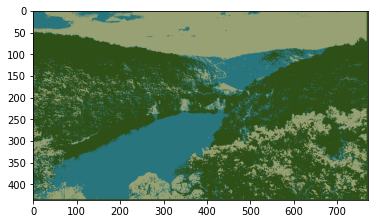

In [ ]:
# k-means segmentation solution
# Based on code from https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python
from google.colab import drive
drive.mount('/content/gdrive')

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import random


def update_centers(data, labels, centers):
  n = len(labels)
  k = len(centers)
  for i in range(k):
    x_points = []
    y_points = []
    z_points = []
    for j in range(n):
      if labels[j] == i:
        x_points.append(data[j][0])
        y_points.append(data[j][1])
        z_points.append(data[j][2])
    centers[i][0] = np.mean(x_points)
    centers[i][1] = np.mean(y_points)
    centers[i][2] = np.mean(z_points)
  print('centers', centers)
  return centers


def euclidean_distance(x, y):
  distance = (x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2
  return math.sqrt(distance)


def kmeans(data, k, max_iterations):
  random.seed()
  n = len(data)
  centers = np.zeros((k, 3))
  for i in range(k):
    r = random.randrange(0, n-1, 1)
    centers[i] = data[r]
  labels = np.zeros((len(data), 1), dtype=int)
  for iteration in range(max_iterations):
    for i in range(n):
      distances = np.zeros(k)
      for j in range(k):
        distances[j] = euclidean_distance(data[i], centers[j])
      labels[i] = [min(range(len(distances)), key=distances.__getitem__)]
    update_centers(data, labels, centers)
  return labels, centers


def main():
  image = cv2.imread('/content/gdrive/My Drive/ML/HW/image.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # reshape the image to a 2D array of pixels and 3 color values (RGB)
  pixel_values = image.reshape((-1, 3))
  # convert to float
  pixel_values = np.float32(pixel_values)

  # define stopping criteria
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

  k = 3
  max_iterations = 2
  labels, (centers) = kmeans(pixel_values, k, max_iterations)
  #_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  # convert back to 8 bit values
  centers = np.uint8(centers)

  # flatten the labels array
  labels = labels.flatten()

  # convert all pixels to the color of the centroids
  segmented_image = centers[labels.flatten()]

  # reshape back to the original image dimension
  segmented_image = segmented_image.reshape(image.shape)
  # show the image
  plt.imshow(segmented_image)
  plt.show()


main()